El porposito de este codigo es analizar la base de datos de la INEGI sobre la cantidad de vehiculos, ya sean autos, motos, camiones o trailers dependiendo del estado en el año 2024

Nos centraremos en hacer una regresion logistica, Linear Discriminant Analysis (LDA) y un Árbol de desiciones, todo esto para realizar fierentes clasificacion de la variable AUTOS_PARTICULARES que sera convertida a CANTIDAD_AUTOS clasificandolos con sus promedio.

Todo esto para analizar que metodologia es mejor para esta base de datos calsificar, principalmente entre LDA y Árbol de desiciones.

Empezaremos convirtiendo la variable AUTOS_PARTICULARES que sera convertida a CANTIDAD_AUTOS clasificandolos con sus promedio.

Una vez hecho realizaremos una separacion en train y test de 80/20 asegurandonos de que no haya fuga de datos poniendo un randomsate esta vez de 23, a su vez pondremos el comando stratyfy=Y que es nuestra variable de salida esto para mantener la uniformidad en los datos.

In [283]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
datos = pd.read_csv("P1-Vehiculos-en-Circulacion-Limpiada.csv")

promedio=datos['AUTO_PARTICULAR'].mean()
promedio = round(promedio)

CantidadAutos=datos['AUTO_PARTICULAR']>promedio
datos=datos.drop(columns='AUTO_PARTICULAR')
CantidadAutos = CantidadAutos.astype(int)


datos = pd.concat([datos,CantidadAutos],axis=1)
datos = datos.rename(columns={'AUTO_PARTICULAR': 'CANTIDAD_AUTOS'})
print(datos.head())

X=datos.drop("CANTIDAD_AUTOS",axis=1)
Y=datos.CANTIDAD_AUTOS

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, train_size = .8,stratify=Y, random_state=23)
print("---Cantidad de clases en los datos originales:")
print(Y.value_counts())
distribucion=Y.value_counts()/Y.value_counts().sum()*100
print("\nDistibucion de clases en los datos originales")
print(distribucion)

distribucion_train=Y_train.value_counts()/Y_train.value_counts().sum()*100
print("\nDistribucion de clases en los datos de entrenamiento:")
print(distribucion_train)

distribucion_test=Y_test.value_counts()/Y_test.value_counts().sum()*100
print("\nDistribucion de clases en los datos de prueba:")
print(distribucion_test)

   AUTO_OFICIAL  AUTO_PUBLICO  CAM_PAS_OFICIAL  CAM_PAS_PUBLICO  \
0           452          4741                5             2497   
1             0            36                0                2   
2             1           168                0                7   
3             2            21                0                0   
4            24           243                0               46   

   CAM_PAS_PARTICULAR  CYC_CARGA_OFICIAL  CYC_CARGA_PUBLICO  \
0                 619                557               3599   
1                  18                  6                 20   
2                  10                 18                  4   
3                   6                  7                  0   
4                  90                 35                180   

   CYC_CARGA_PARTICULAR  MOTO_OFICIAL  MOTO_DE_ALQUILER  MOTO_PARTICULAR  \
0                112480           299                 0            89105   
1                  5689             2                 0           

Como pudimos observar si se mantuvo una separacion de datos de manera uniforme, asi que en base a esta separacion generaremos un modelo de regresion Logística con la funcion sm.GLM(), lo convertiremos a fit() e imprimiremos todo lo que este modelo nos arruja con un summary para asi poder observar cuales variables son las mas significativas.

Una vez el programa sepa cuales son las variables más significativas modificaremos el train y test de la X para que solo ahore guarde estas 2 variables más relevantes para trabajar con ellas en adelante.

Corre una regresión logística simple con la función GLM de statsmodels con todas tus
variables de entrada e imprime el resumen del modelo en consola. Indica cuáles son las
2 variables más relevantes para este estudio y selecciónalas, eliminando todas las demás
variables de tus datos de entrenamiento y prueba.

Para terminar con esta parte crearemos otro modelo logisitico pero ahora solo con estas variables más relevantes.

In [284]:
import statsmodels.api as sm
model = sm.GLM(Y_train, X_train, family=sm.families.Binomial())
results = model.fit()
print(results.summary())

p_values = results.pvalues.sort_values()
print('\nValores p ordenados de forma ascendente:')
print(p_values)

variable_relev = p_values.index[0:2]
print('\nLas 2 variables más relevantes son:', variable_relev[0], 'y', variable_relev[1])

X_train_relevantes = X_train[variable_relev]
X_test_relevantes = X_test[variable_relev]

model = sm.GLM(Y_train, X_train_relevantes, family=sm.families.Binomial())
results = model.fit()
print(results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:         CANTIDAD_AUTOS   No. Observations:                 1982
Model:                            GLM   Df Residuals:                     1971
Model Family:                Binomial   Df Model:                           10
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1302.5
Date:                Thu, 02 Oct 2025   Deviance:                       2605.1
Time:                        10:09:14   Pearson chi2:                 2.52e+03
No. Iterations:                     9   Pseudo R-squ. (CS):            -0.8306
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
AUTO_OFICIAL             0.0019 

Como podemos observar las variables mas relevantes son CAM_PAS_PUBLICO y CYC_CARGA_PARTICULAR, por lo que trabajaremos con ellas. Tambien observando su modelo logistico puede que haya empeorado, reduciendo su signficacncia pero aun asi son muy relevantes, asi que empezaremos a trabajar con ellas.

Ahora crearemos un modelo para LDA, lo primero que ahremos sera reducir el tamaño de nuestro dataset con un np.log1p para trabajar de mejor manera y evitar colisiones si hay 0, esto lo haremos en nuestro X_train para los variables que tenemos.en donde le diremos que nuestro dataset sera X_train definiendo nuestra X y Y y que se divida mediante la clase CANTIDAD_AUTOS.

Mediante el sns.scatterplot para graficar estas 2 variables de manera correcta para el modelo LDA

Para terminar crearemos el discrminante para generar donde es que se separa los 0 y 1 de la CANTIDAD_AUTOS

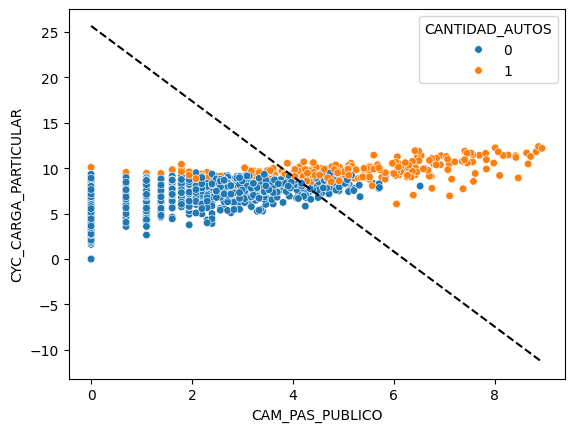

In [285]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

X_train['CAM_PAS_PUBLICO'] = np.log1p(X_train['CAM_PAS_PUBLICO'])
X_train['CYC_CARGA_PARTICULAR'] = np.log1p(X_train['CYC_CARGA_PARTICULAR'])

lda = LDA().fit(X_train[['CAM_PAS_PUBLICO','CYC_CARGA_PARTICULAR']], Y_train)

sns.scatterplot(
    data=X_train,
    x='CAM_PAS_PUBLICO', y='CYC_CARGA_PARTICULAR',
    hue=Y_train, s=30
)

if len(lda.classes_) == 2:
    w = lda.coef_[0]; b = lda.intercept_[0]
    xs = np.linspace(X_train['CAM_PAS_PUBLICO'].min(), X_train['CAM_PAS_PUBLICO'].max(), 200)
    if w[1] != 0:
        ys = -(w[0]/w[1]) * xs - b / w[1]
        plt.plot(xs, ys, '--', color='black')
    else:
        plt.axvline(-b / w[0], linestyle='--', color='black')

plt.show()


Podemos observar que la linea discriminante si es bastante precisa aunque no capte todos los 0 y 1 es bastante mas acercado de lo esperado, asi ahora realizaremos un arbol de desicion para ver que tanto acierta este modelo.

Primero crearemos el modelo del abrol sin podar y permitiremos que crezca indefinidamente, posteriormente calcularemos la yhat, su acurracy y el f1 para ver posteriormente si el podado fue efectivo.

Ahora mediante validazión curzada con 4 folds obtendremos el mejor alpha para empezar a podar de la manera mas eficaz.
Repetiremos este proceso pero ahora para el arbol podado e imprimiremos los datos anteriores y un grafico del Árbol ahora podado.



Árbol sin Podar

Accuracy inicial: 0.13911290322580644
F1-score inicial: 0.21072088724584104

Mejor alpha: 0.002598393574297189

Árbol Podado

Accuracy final: 0.13911290322580644
F1-score final: 0.21072088724584104



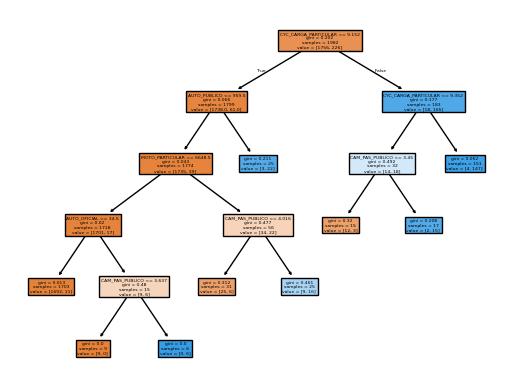

In [286]:
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import cross_val_score, StratifiedKFold

tree=DTC().fit(X_train, Y_train)

yhat0 = tree.predict(X_test)
acc0 = accuracy_score(Y_test, yhat0)
f10 = f1_score(Y_test, yhat0)

print('Árbol sin Podar')
print("\nAccuracy inicial:",acc0)
print("F1-score inicial:",f10)

skf = StratifiedKFold(n_splits=4)
ccp = np.linspace(0.001, 0.2, 250)
cv_scores = []

for alpha in ccp:
    pruned_tree = DTC(ccp_alpha=alpha)
    cv_scores.append(np.mean(cross_val_score(pruned_tree, X_train, Y_train, cv=skf, scoring='f1')))
alpha = ccp[np.argmax(cv_scores)]

print("\nMejor alpha:",alpha)

pruned_tree = DTC(ccp_alpha=alpha).fit(X_train, Y_train)
plot_tree(pruned_tree, filled=True, feature_names=X_train.columns);

yhat_p = pruned_tree.predict(X_test)
acc_p = accuracy_score(Y_test, yhat_p)
f1_p = f1_score(Y_test, yhat_p)
print('\nÁrbol Podado')
print("\nAccuracy final:",acc_p)
print("F1-score final:",f1_p)
print()


Como observamos aunque se obtuvo el mejor alfa posible, las ramas no cambiaron, esto se debe por la cantidad de 0 y 1 que poseen estas variables, por lo que no se pudo encontrar para el programa una mejor forma que el arbol original que se genero en primer lugar.

Para terminar imprimiremos una matriz de confusion y un reporte de las calsificaciones del modelo LDA y del Árbol de decisiones para comparar, esto mediante la funcion import confusion_matrix y la classification_report.
A su vez tambien imprimiremos algunas metricas necesarias.

In [287]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, roc_auc_score

yhat_lda = lda_model.predict(X_test_lda)

acc_lda = accuracy_score(Y_test, yhat_lda)
f1_lda = f1_score(Y_test, yhat_lda)
roc_auc_lda = roc_auc_score(Y_test, yhat_lda)
confusion_lda = confusion_matrix(Y_test, yhat_lda)

print("Métricas para el modelo LDA:")
print("Accuracy:", acc_lda)
print("F1-score:", f1_lda)
print("AUC-ROC:", roc_auc_lda)
print("Matriz de confusión:\n", confusion_lda)
print("Reporte de clasificación:\n", classification_report(Y_test, yhat_lda))

print("\nMatriz de confusión del modelo Árbol de Decisión:")
print(confusion_matrix(Y_test, yhat_p))
print("\nReporte de clasificación del modelo Árbol de Decisión:")
print(classification_report(Y_test, yhat_p))

acc_tree = accuracy_score(Y_test, yhat_p)
f1_tree = f1_score(Y_test, yhat_p)
roc_auc_tree = roc_auc_score(Y_test, yhat_p)

print("\nMétricas para el modelo Árbol de Decisión:")
print("Accuracy:", acc_tree)
print("F1-score:", f1_tree)
print("AUC-ROC:", roc_auc_tree)

Métricas para el modelo LDA:
Accuracy: 0.15725806451612903
F1-score: 0.21428571428571427
AUC-ROC: 0.5239179954441913
Matriz de confusión:
 [[ 21 418]
 [  0  57]]
Reporte de clasificación:
               precision    recall  f1-score   support

           0       1.00      0.05      0.09       439
           1       0.12      1.00      0.21        57

    accuracy                           0.16       496
   macro avg       0.56      0.52      0.15       496
weighted avg       0.90      0.16      0.11       496


Matriz de confusión del modelo Árbol de Decisión:
[[ 12 427]
 [  0  57]]

Reporte de clasificación del modelo Árbol de Decisión:
              precision    recall  f1-score   support

           0       1.00      0.03      0.05       439
           1       0.12      1.00      0.21        57

    accuracy                           0.14       496
   macro avg       0.56      0.51      0.13       496
weighted avg       0.90      0.14      0.07       496


Métricas para el modelo Ár

Se puede observar que las metricas obtenidas del modelo de LDA son mayores tanto en accuracy y F1 aunque tan solo por 2% de diferencia, lo que tambien nos indica que a lo mejor estos modelos no son precisamente buenos para estas 2 variables por lo que yo propondria analizarlo por otros metodos.

En conlusión el metodo mas eficiente fue el del LDA.